In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import math
import pandas as pd
from glob import iglob
import numpy as np
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
import time
from utils import plot_confusion_matrix
from keras.utils import plot_model

In [3]:
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('../data/**/gafgyt_attacks/*.csv', recursive=True)), ignore_index=True)
print('Loaded, shape: ')
print(df_gafgyt.shape)
df_gafgyt['class'] = 'gafgyt'
print('Loading mirai data')
df_mirai = pd.concat((pd.read_csv(f) for f in iglob('../data/**/mirai_attacks/*.csv', recursive=True)), ignore_index=True)
print('Loaded, shape: ')
print(df_mirai.shape)
df_mirai['class'] = 'mirai'
print('Loading benign data')
df_benign = pd.concat((pd.read_csv(f) for f in iglob('../data/**/benign_traffic.csv', recursive=True)), ignore_index=True)
print('Loaded, shape: ')
print(df_benign.shape)
df_benign['class'] = 'benign'
df = df_benign.append(df_gafgyt.sample(n=df_benign.shape[0], random_state=17)).append(df_mirai.sample(n=df_benign.shape[0], random_state=17))

Loaded, shape: 
(1032056, 115)
Loading mirai data
Loaded, shape: 
(3668402, 115)
Loading benign data
Loaded, shape: 
(555932, 115)


In [4]:
def create_model(input_dim, hidden_layer_size, num_of_classes):
    model = Sequential()
    model.add(Dense(hidden_layer_size, activation="tanh", input_shape=(input_dim,)))
    model.add(Dense(hidden_layer_size, activation="tanh"))
    model.add(Dense(num_of_classes))
    model.add(Activation('softmax'))
    return model

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df, pd.get_dummies(df['class']), test_size=0.2, random_state=42)

In [6]:
classes = ['benign', 'gafgyt', 'mirai']

In [7]:
scored = []
indices = {}
shps = {}
for cl in classes:
    indices[cl] = x_train['class'] == cl
    shps[cl] =  x_train[indices[cl]].shape[0]
        
for col in x_train.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = x_train[col].mean()
    
    for cl in classes:
        num += (shps[cl] / x_train.shape[0]) * (m - x_train[indices[cl]][col].mean())**2
        den += (shps[cl] / x_train.shape[0]) * x_train[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:3]

[{'feature': 'MI_dir_L3_weight', 'score': 1.9636335509506944},
 {'feature': 'H_L3_weight', 'score': 1.9636333188784434},
 {'feature': 'MI_dir_L5_weight', 'score': 1.9311612895829293}]

In [7]:
with open('classification_scores.csv', 'w+') as file:
    lines = ['Feature,Score\n']
    for s in scored:
        lines.append(s['feature'] + ',' + "{0:.2f}".format(s['score']) + '\n')
    file.writelines(lines)

In [13]:
acs = []
for top_n_features in [115]:
    fs = [it['feature'] for it in scored[:top_n_features]]
    X_train = x_train[fs]
    X_test = x_test[fs]
    scaler = StandardScaler()
    print('Transforming data')
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = create_model(top_n_features, 8, 3)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cp = ModelCheckpoint(filepath=f'./models/model_{top_n_features}.h5',
                               save_best_only=True,
                               verbose=0)
    es = EarlyStopping(patience=3, monitor='val_acc')
    epochs = 100
    start=time.time()
    history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[cp, es])
    #model = load_model(f'./models/model_{top_n_features}.h5')
    print('time ' + str(time.time() - start))
    #print('Model evaluation')
    print('Loss, Accuracy')
    ev = model.evaluate(X_test, y_test)
    print(ev)
    #print()
    print()
    y_pred_proba = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_test_classes = np.argmax(y_test.values, axis=1)
    print('accuracy')
    acc = accuracy_score(y_test_classes, y_pred_classes)
    acs.append(acc)
    print(acc)
    cnf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    print('Confusion matrix')
    print('benign  gafgyt  mirai')
    print(cnf_matrix)

Transforming data
Train on 1067388 samples, validate on 266848 samples
Epoch 1/40
1067388/1067388 [==============================] - 52s 49us/step - loss: 0.0119 - acc: 0.9971 - val_loss: 0.0015 - val_acc: 0.9996
Epoch 2/40
1067388/1067388 [==============================] - 52s 49us/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0014 - val_acc: 0.9997
Epoch 3/40
1067388/1067388 [==============================] - 53s 50us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 8.3507e-04 - val_acc: 0.9998
Epoch 4/40
1067388/1067388 [==============================] - 51s 48us/step - loss: 0.0011 - acc: 0.9997 - val_loss: 8.5494e-04 - val_acc: 0.9998
Epoch 5/40
1067388/1067388 [==============================] - 50s 47us/step - loss: 0.0012 - acc: 0.9997 - val_loss: 8.9509e-04 - val_acc: 0.9998
Epoch 6/40
1067388/1067388 [==============================] - 51s 47us/step - loss: 0.0011 - acc: 0.9997 - val_loss: 7.2099e-04 - val_acc: 0.9998
Epoch 7/40
1067388/1067388 [==============================] -

In [ ]:
plt.xlabel('Features')
plt.ylabel('Accuracy')
#plt.xticks([2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 115])
plt.plot([2, 3, 4, 5, 6, 7, 8, 9, 10], acs)

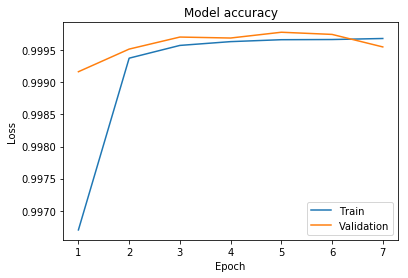

In [9]:
epochs = len(history.history['acc'])
plt.plot(range(1,epochs+1), history.history['acc'])
plt.plot(range(1,epochs+1), history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.xticks(list(range(1,epochs+1)))
plt.show()

In [24]:
plot_model(model, to_file='classification_model.png', show_shapes=True)

Confusion matrix, without normalization
[[110860      0      2]
 [    45 111106      7]
 [    20     14 111506]]


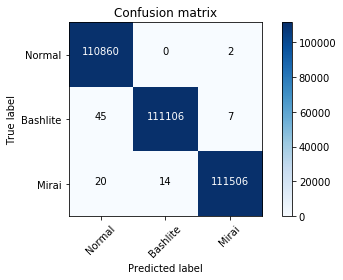

In [43]:
plot_confusion_matrix(cnf_matrix, ['Normal', 'Bashlite', 'Mirai'])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 27        
_________________________________________________________________
activation_10 (Activation)   (None, 3)                 0         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [37]:
class ModelWrapper:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def scale_predict(self, x):
        x = self.scaler.transform(x)
        return self.model.predict(x)

In [45]:
m = ModelWrapper(model, scaler)

In [46]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train[fs].values, feature_names=fs, class_names=classes, discretize_continuous=True)

In [79]:
exp = explainer.explain_instance(df_mirai[fs].values[500], m.scale_predict, num_features=5, top_labels=3)
exp.show_in_notebook(show_table=True, show_all=False)
#print(exp.as_list(label=1))
#print(exp.as_list(label=2))

In [80]:
exp.as_list(label=2)

[('HH_jit_L0.1_weight <= 1.21', 0.14469073957767725),
 ('HH_L0.1_weight <= 1.21', 0.11592591455755855),
 ('3427.45 < MI_dir_L0.1_weight <= 6431.98', 0.10804481702118346),
 ('3427.45 < H_L0.1_weight <= 6431.98', 0.10738773790902614),
 ('MI_dir_L5_weight > 155.08', 0.1030884779229)]

In [87]:
",".join(["{0:.2f}".format(s) for s in df_mirai[fs].values[500]])

'259.08,259.08,171.54,171.54,679.27,679.27,4301.86,4301.86,6672.74,6672.74,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,70.78,70.78,70.87,70.87,71.73,71.73,72.60,72.60,26.66,26.66,72.79,72.79,35.01,35.01,34.27,34.27,17.63,17.63,1.00,1.00,15.42,15.42,1507657074.30,1507657074.30,1507657074.30,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,1507657074.30,1507657074.30,0.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00'